##  Problem Formulation

The objective of this project is to **predict whether a customer will purchase a bank product or service** based on their **demographic characteristics** and **historical marketing interactions**.

### Business Perspective
Banks conduct marketing campaigns to promote financial products, but contacting every customer is costly and inefficient. An intelligent prediction system helps the bank **target customers who are most likely to subscribe**, improving conversion rates while reducing operational costs.

### Machine Learning Perspective
This problem is formulated as a **Supervised Binary Classification** task.

- **Input Features (X)**:  
  Customer demographic and behavioral attributes such as age, job, marital status, balance, contact type, campaign history, and previous outcomes.

- **Target Variable (y)**:  
  `y ∈ {0, 1}`, where  
  `1` → Customer purchases the product (`yes`)  
  `0` → Customer does not purchase the product (`no`)

- **Learning Objective**:  
  Learn a decision function  
  $$
  f(X) \rightarrow \{0,1\}
  $$
  That accurately predicts customer purchase behavior.

### Model Choice Justification
A **Decision Tree Classifier** is selected because it:
- Handles both numerical and categorical data
- Requires minimal preprocessing
- Captures non-linear decision boundaries
- Produces interpretable, rule-based predictions
- Offers fast training and inference suitable for deployment

### Success Criteria
Model performance is evaluated using:
- Precision, Recall, and F1-score
- Confusion Matrix analysis
- Emphasis on Recall for the positive class (potential buyers)

This formulation ensures alignment between **business goals**, **statistical learning theory**, and **deployment constraints**.
$$
  f(X) \rightarrow \{0,1\}
$$

## Data understanding

In [1]:
import os, glob
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 220)

bank_path = "/kaggle/input/bank-marketing-dataset/bank"
bank_add_path = "/kaggle/input/bank-marketing-dataset/bank-additional/bank-additional"

def read_csv_smart(path):
    for sep in [";", ",", "\t", "|"]:
        try:
            df = pd.read_csv(path, sep=sep)
            if df.shape[1] > 1:
                return df, sep
        except Exception:
            pass
    df = pd.read_csv(path)
    return df, "auto"

def pick_full_dataset(folder, prefer="full"):
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No .csv found in: {folder}")
    full = [f for f in files if prefer in os.path.basename(f).lower()]
    chosen = full[0] if full else files[0]
    df, sep = read_csv_smart(chosen)
    return df, chosen, sep

df_bank, bank_file, bank_sep = pick_full_dataset(bank_path, prefer="full")
df_add, add_file, add_sep = pick_full_dataset(bank_add_path, prefer="full")

def dataset_report(df, name):
    print(f"\n{'='*110}\n{name}\n{'='*110}")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    display(df.head(5))
    print("\nDTypes (counts):")
    display(df.dtypes.astype(str).value_counts().rename_axis("dtype").reset_index(name="count"))
    dup = df.duplicated().sum()
    print(f"\nDuplicate rows: {dup:,} ({dup/len(df):.2%})")
    na = df.isna().sum().sort_values(ascending=False)
    na = na[na > 0]
    print("\nMissing values (NaN):")
    display(na.to_frame("missing_count").assign(missing_pct=lambda x: (x["missing_count"]/len(df)).round(4)) if len(na) else pd.DataFrame({"missing_count": []}))
    obj_cols = df.select_dtypes(include=["object"]).columns
    if len(obj_cols):
        unk = (df[obj_cols].astype(str).apply(lambda s: s.str.strip().str.lower()).eq("unknown")).sum().sort_values(ascending=False)
        unk = unk[unk > 0]
        print('\n"unknown" frequency (categorical-coded missingness):')
        display(unk.to_frame("unknown_count").assign(unknown_pct=lambda x: (x["unknown_count"]/len(df)).round(4)) if len(unk) else pd.DataFrame({"unknown_count": []}))
    print("\nUnique values per column (top 20):")
    nun = df.nunique(dropna=False).sort_values(ascending=False).head(20)
    display(nun.to_frame("n_unique"))
    if "y" in df.columns:
        y_raw = df["y"].astype(str).str.strip().str.lower()
        y_map = {"yes": 1, "no": 0, "true": 1, "false": 0, "1": 1, "0": 0}
        y = y_raw.map(y_map)
        if y.isna().any():
            print("\nTarget `y` unique values (could not map cleanly to {0,1}):")
            display(pd.Series(y_raw.unique()).to_frame("unique_y_values"))
        else:
            dist = y.value_counts().sort_index()
            print("\nTarget distribution (0=no, 1=yes):")
            display(dist.to_frame("count").assign(pct=lambda x: (x["count"]/len(df)).round(4)))
            p1 = dist.get(1, 0) / len(df)
            base_acc = max(p1, 1 - p1)
            print(f"\nBaseline accuracy (majority class): {base_acc:.4f}")
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols):
        print("\nNumeric summary (describe with robust quantiles):")
        display(df[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T)
        skew = df[num_cols].skew(numeric_only=True).sort_values(ascending=False).to_frame("skewness")
        kurt = df[num_cols].kurtosis(numeric_only=True).sort_values(ascending=False).to_frame("kurtosis")
        print("\nDistribution shape (skewness/kurtosis) top 15:")
        display(skew.join(kurt, how="outer").head(15))
        corr = df[num_cols].corr(numeric_only=True).abs()
        np.fill_diagonal(corr.values, 0)
        pairs = (corr.stack().sort_values(ascending=False).reset_index().rename(columns={"level_0":"feature_1","level_1":"feature_2",0:"abs_corr"}))
        pairs = pairs[pairs["feature_1"] < pairs["feature_2"]].head(15)
        print("\nTop absolute correlations among numeric features:")
        display(pairs)
    if "y" in df.columns:
        y_raw = df["y"].astype(str).str.strip().str.lower()
        y_map = {"yes": 1, "no": 0, "true": 1, "false": 0, "1": 1, "0": 0}
        y = y_raw.map(y_map)
        if not y.isna().any():
            print("\nUnivariate association with target (screening):")
            assoc_rows = []
            if len(num_cols):
                for c in num_cols:
                    x = df[c]
                    m = x.notna() & y.notna()
                    if m.sum() > 10 and x[m].nunique() > 1:
                        r, p = pointbiserialr(y[m].astype(float), x[m].astype(float))
                        assoc_rows.append((c, "numeric", float(r), float(p), int(m.sum())))
            cat_cols = [c for c in df.columns if c not in num_cols and c != "y"]
            for c in cat_cols:
                s = df[c].astype(str).fillna("NA")
                m = y.notna()
                if s[m].nunique() > 1:
                    ct = pd.crosstab(s[m], y[m])
                    if ct.shape[0] > 1 and ct.shape[1] == 2:
                        chi2, p, dof, exp = chi2_contingency(ct)
                        assoc_rows.append((c, "categorical", float(chi2), float(p), int(m.sum())))
            assoc = pd.DataFrame(assoc_rows, columns=["feature", "type", "statistic", "p_value", "n_used"])
            display(assoc.sort_values(["p_value","statistic"], ascending=[True, False]).head(25) if len(assoc) else pd.DataFrame({"feature": []}))
            X = df.drop(columns=["y"]).copy()
            for c in X.columns:
                if X[c].dtype == "object":
                    X[c] = LabelEncoder().fit_transform(X[c].astype(str).fillna("NA"))
            X = X.apply(pd.to_numeric, errors="coerce").fillna(-1)
            mi = mutual_info_classif(X, y.astype(int), discrete_features="auto", random_state=42)
            mi_tbl = pd.DataFrame({"feature": X.columns, "mutual_info": mi}).sort_values("mutual_info", ascending=False).head(25)
            print("\nMutual information ranking (nonparametric):")
            display(mi_tbl)
    if "duration" in df.columns:
        print("\nLeakage risk check (`duration`):")
        if "y" in df.columns:
            y_raw = df["y"].astype(str).str.strip().str.lower()
            y_map = {"yes": 1, "no": 0, "true": 1, "false": 0, "1": 1, "0": 0}
            y = y_raw.map(y_map)
            if not y.isna().any() and pd.api.types.is_numeric_dtype(df["duration"]):
                q = df.groupby(y)["duration"].quantile([0.0, 0.25, 0.5, 0.75, 0.9, 0.99]).unstack()
                q.index = q.index.map({0: "no(0)", 1: "yes(1)"})
                display(q)
        print("Note: `duration` is known only after a call; keep it for benchmarking, drop it for realistic pre-call prediction.")

print("Available files:")
print("BANK:", sorted([os.path.basename(p) for p in glob.glob(os.path.join(bank_path, '*.csv'))]))
print("BANK-ADDITIONAL:", sorted([os.path.basename(p) for p in glob.glob(os.path.join(bank_add_path, '*.csv'))]))

use_additional = True
df = df_add.copy() if use_additional else df_bank.copy()
chosen = add_file if use_additional else bank_file
chosen_sep = add_sep if use_additional else bank_sep

print(f"\nChosen dataset for modeling: {os.path.basename(chosen)} | sep='{chosen_sep}'")
dataset_report(df, "DATA UNDERSTANDING REPORT — SELECTED DATASET")


Available files:
BANK: ['bank-full.csv', 'bank.csv']
BANK-ADDITIONAL: ['bank-additional-full.csv', 'bank-additional.csv']

Chosen dataset for modeling: bank-additional-full.csv | sep=';'

DATA UNDERSTANDING REPORT — SELECTED DATASET
Shape: 41,188 rows × 21 columns


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



DTypes (counts):


,dtype,count
0,object,11
1,int64,5
2,float64,5



Duplicate rows: 12 (0.03%)

Missing values (NaN):


,missing_count



"unknown" frequency (categorical-coded missingness):


,unknown_count,unknown_pct
default,8597,0.2087
education,1731,0.0420
housing,990,0.0240
loan,990,0.0240
job,330,0.0080
marital,80,0.0019



Unique values per column (top 20):


,n_unique
duration,1544
euribor3m,316
age,78
campaign,42
pdays,27
cons.price.idx,26
cons.conf.idx,26
job,12
nr.employed,11
emp.var.rate,10



Target distribution (0=no, 1=yes):


,count,pct
y,,
0,36548,0.8873
1,4640,0.1127



Baseline accuracy (majority class): 0.8873

Numeric summary (describe with robust quantiles):


,count,mean,std,min,1%,5%,50%,95%,99%,max
age,41188.0,40.024060,10.421250,17.000,23.00000,26.000,38.000,58.000,71.000,98.000
duration,41188.0,258.285010,259.279249,0.000,11.00000,36.000,180.000,752.650,1271.130,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.00000,1.000,2.000,7.000,14.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,3.00000,999.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.00000,0.000,0.000,1.000,2.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-3.40000,-2.900,1.100,1.400,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,92.20100,92.713,93.749,94.465,94.465,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-49.50000,-47.100,-41.800,-33.600,-26.900,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,0.65848,0.797,4.857,4.966,4.968,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,4963.60000,5017.500,5191.000,5228.100,5228.100,5228.100



Distribution shape (skewness/kurtosis) top 15:


,skewness,kurtosis
age,0.784697,0.791312
campaign,4.762507,36.979795
cons.conf.idx,0.303180,-0.358558
cons.price.idx,-0.230888,-0.829809
duration,3.263141,20.247938
emp.var.rate,-0.724096,-1.062632
euribor3m,-0.709188,-1.406803
nr.employed,-1.044262,-0.003760
pdays,-4.922190,22.229463
previous,3.832042,20.108816



Top absolute correlations among numeric features:


,feature_1,feature_2,abs_corr
1,emp.var.rate,euribor3m,0.972245
3,euribor3m,nr.employed,0.945154
4,emp.var.rate,nr.employed,0.906970
7,cons.price.idx,emp.var.rate,0.775334
8,cons.price.idx,euribor3m,0.688230
10,pdays,previous,0.587514
13,cons.price.idx,nr.employed,0.522034
15,nr.employed,previous,0.501333
17,euribor3m,previous,0.454494
19,emp.var.rate,previous,0.420489



Univariate association with target (screening):


,feature,type,statistic,p_value,n_used
19,poutcome,categorical,4230.523798,0.000000e+00,41188
17,month,categorical,3101.149351,0.000000e+00,41188
1,duration,numeric,0.405274,0.000000e+00,41188
4,previous,numeric,0.230181,0.000000e+00,41188
5,emp.var.rate,numeric,-0.298334,0.000000e+00,41188
8,euribor3m,numeric,-0.307771,0.000000e+00,41188
3,pdays,numeric,-0.324914,0.000000e+00,41188
9,nr.employed,numeric,-0.354678,0.000000e+00,41188
10,job,categorical,961.242440,4.189763e-199,41188
16,contact,categorical,862.318364,1.525986e-189,41188



Mutual information ranking (nonparametric):


,feature,mutual_info
10,duration,0.077351
18,euribor3m,0.073186
16,cons.price.idx,0.068945
17,cons.conf.idx,0.067400
19,nr.employed,0.063110
15,emp.var.rate,0.056823
12,pdays,0.041711
14,poutcome,0.035422
8,month,0.028797
13,previous,0.018647



Leakage risk check (`duration`):


,0.00,0.25,0.50,0.75,0.90,0.99
y,,,,,,
no(0),0.0,95.0,163.5,279.00,447.0,1018.53
yes(1),37.0,253.0,449.0,741.25,1070.1,1880.05


Note: `duration` is known only after a call; keep it for benchmarking, drop it for realistic pre-call prediction.


## Data Cleaning

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, glob
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 220)

bank_add_path = "/kaggle/input/bank-marketing-dataset/bank-additional/bank-additional"

def _read_csv_smart(path):
    for sep in [";", ",", "\t", "|"]:
        try:
            d = pd.read_csv(path, sep=sep)
            if d.shape[1] > 1:
                return d, sep
        except Exception:
            pass
    return pd.read_csv(path), "auto"

files = sorted(glob.glob(os.path.join(bank_add_path, "*.csv")))
chosen = [f for f in files if "full" in f.lower()][0]
df_raw, sep = _read_csv_smart(chosen)

target = "y"
df1 = df_raw.copy()
df1.columns = df1.columns.str.strip()

obj_cols = df1.select_dtypes(include="object").columns
for c in obj_cols:
    df1[c] = df1[c].astype(str).str.strip()

y_map = {"yes": 1, "no": 0}
df1[target] = df1[target].str.lower()
df1 = df1[df1[target].isin(y_map)]
df1["y_bin"] = df1[target].map(y_map)

df1 = df1.drop_duplicates().reset_index(drop=True)

for c in obj_cols:
    df1[c] = df1[c].replace(
        {"unknown": "Unknown", "nan": "Unknown", "None": "Unknown", "<NA>": "Unknown"}
    ).fillna("Unknown")

if "pdays" in df1.columns:
    df1["previously_contacted"] = (df1["pdays"] != 999).astype(int)
    df1.loc[df1["pdays"] == 999, "pdays"] = np.nan

num_cols = df1.select_dtypes(include=np.number).columns.drop("y_bin")
df1[num_cols] = df1[num_cols].apply(pd.to_numeric, errors="coerce")
df1[num_cols] = df1[num_cols].fillna(df1[num_cols].median())

for c in num_cols:
    q01, q99 = df1[c].quantile([0.01, 0.99])
    df1[c] = df1[c].clip(q01, q99)

df_clean = df1.drop(columns=["duration"], errors="ignore")

X = df_clean.drop(columns=[target, "y_bin"])
y = df_clean["y_bin"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    verbose_feature_names_out=False
)

X_enc = preprocess.fit_transform(X)
feat_names = preprocess.get_feature_names_out()

vt = VarianceThreshold(0.0)
X_final = vt.fit_transform(X_enc)
feat_final = feat_names[vt.get_support()]

df_clean_ready = pd.DataFrame(X_final, columns=feat_final)
df_clean_ready["y"] = y.values

out_file = "bank_additional_full_cleaned_ready.csv"
df_clean_ready.to_csv(out_file, index=False)

print("DATA CLEANING COMPLETED SUCCESSFULLY")
print(f"Final shape: {df_clean_ready.shape}")


DATA CLEANING COMPLETED SUCCESSFULLY
Final shape: (41176, 64)


In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("bank_additional_full_cleaned_ready.csv")

target = "y"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]

X_num = df[num_cols].copy()
y = df[target].copy()

scaler = StandardScaler()
X_std = scaler.fit_transform(X_num)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_std)

pc_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

New_DF = pd.DataFrame(X_pca, columns=pc_cols)
New_DF[target] = y.values

New_DF.to_csv("bank_additional_full_PCA_ready.csv", index=False)

pca_report = pd.DataFrame({
    "n_original_features": [X_num.shape[1]],
    "n_principal_components": [X_pca.shape[1]],
    "explained_variance_95pct": [pca.explained_variance_ratio_.sum()],
})

print("PCA REPORT")
display(pca_report)



PCA REPORT


,n_original_features,n_principal_components,explained_variance_95pct
0,63,41,0.954883


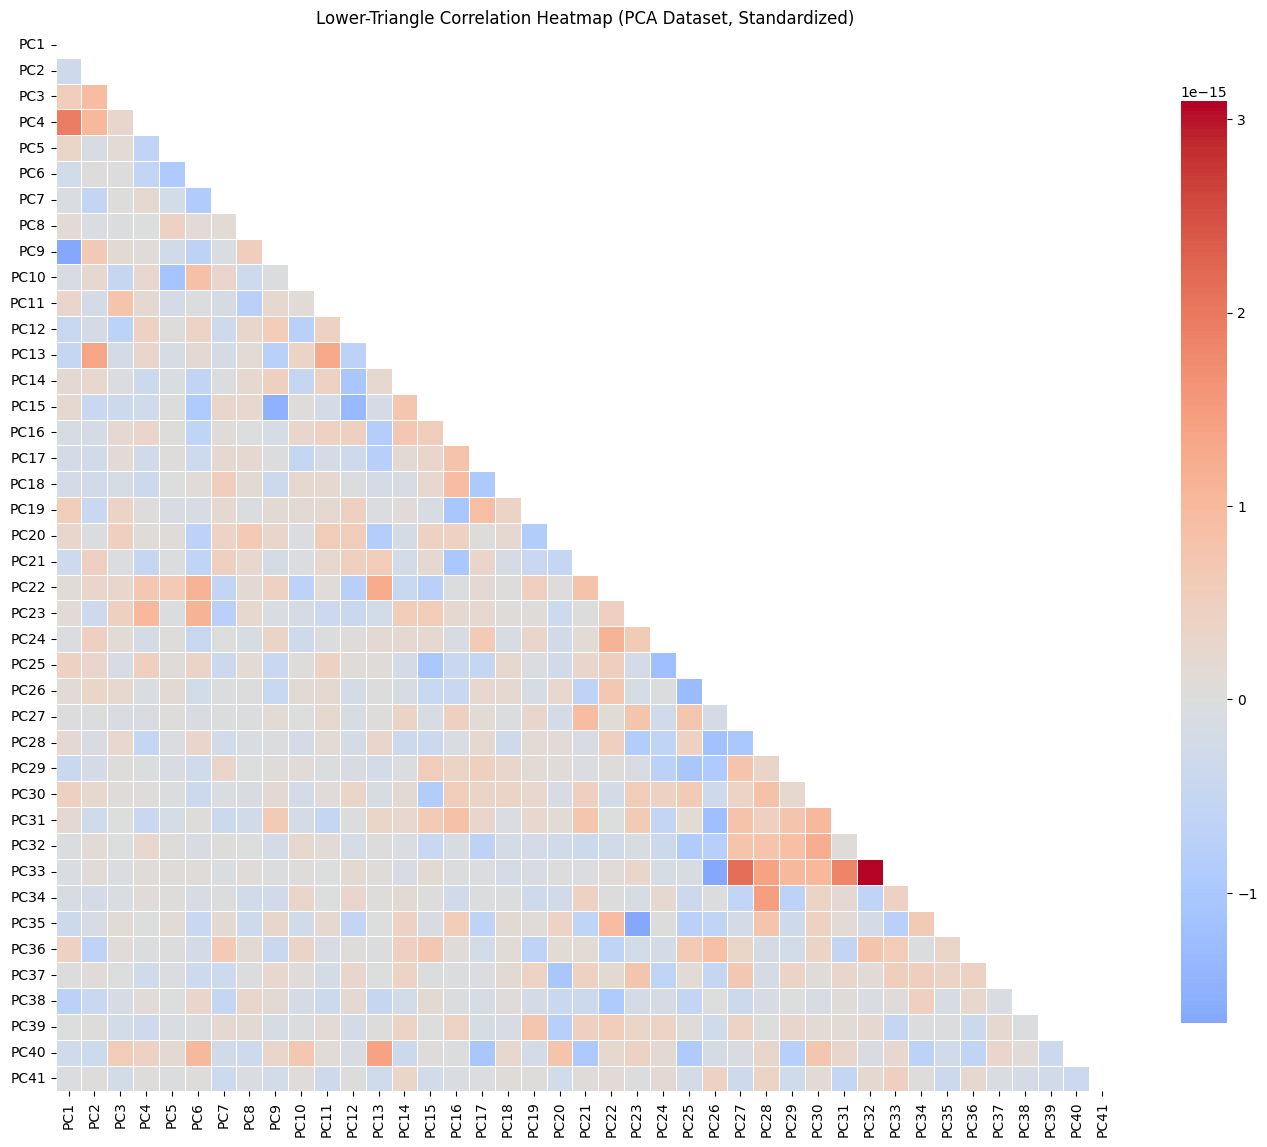

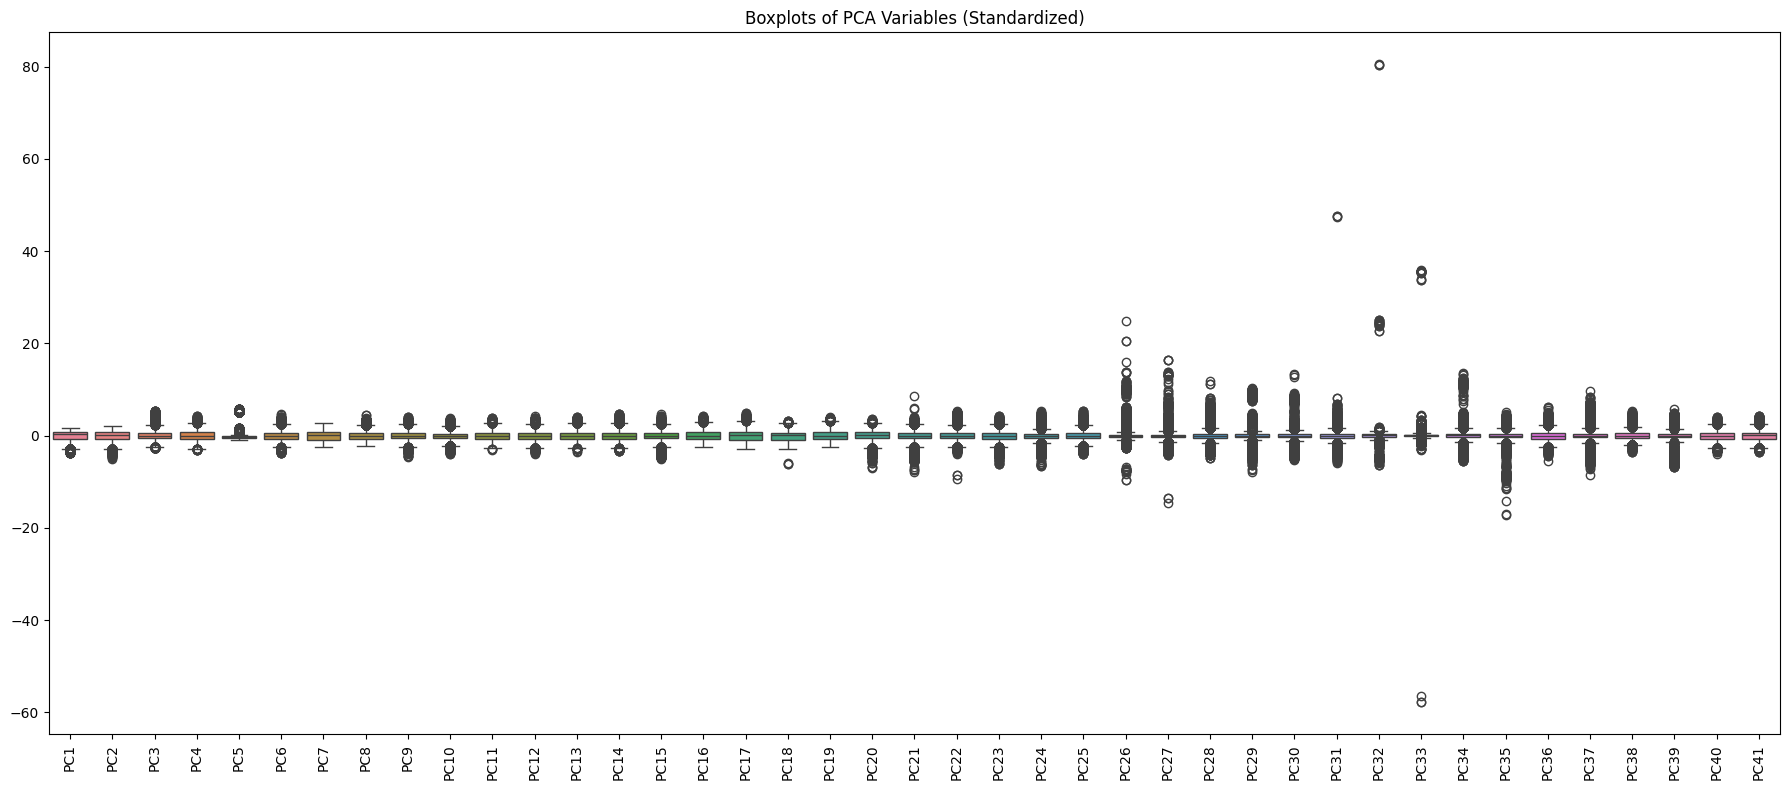

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

df = pd.read_csv("bank_additional_full_PCA_ready.csv")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "y"]

X = df[num_cols].copy()

scaler = StandardScaler()
X_std = pd.DataFrame(
    scaler.fit_transform(X),
    columns=num_cols
)

corr = X_std.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Lower-Triangle Correlation Heatmap (PCA Dataset, Standardized)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 8))
sns.boxplot(data=X_std)
plt.title("Boxplots of PCA Variables (Standardized)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Feature Engineering

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

df = pd.read_csv("bank_additional_full_PCA_ready.csv")

target = "y"
y = df[target].astype(int).copy()
X = df.drop(columns=[target]).copy()

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

X[num_cols] = X[num_cols].apply(pd.to_numeric, errors="coerce")
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

for c in cat_cols:
    X[c] = (
        X[c].astype(str)
        .str.strip()
        .replace({"unknown": "Unknown", "nan": "Unknown", "None": "Unknown", "<NA>": "Unknown"})
        .fillna("Unknown")
    )

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

feature_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("variance_filter", VarianceThreshold(threshold=0.0)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])

X_train_fe = feature_pipeline.fit_transform(X_train)
X_test_fe  = feature_pipeline.transform(X_test)

pca = feature_pipeline.named_steps["pca"]
pc_cols = [f"PC{i+1}" for i in range(pca.n_components_)]

train_fe_df = pd.DataFrame(X_train_fe, columns=pc_cols)
train_fe_df[target] = y_train.values

test_fe_df = pd.DataFrame(X_test_fe, columns=pc_cols)
test_fe_df[target] = y_test.values

PCA_Final_Output = pd.concat(
    [train_fe_df.assign(split="train"), test_fe_df.assign(split="test")],
    ignore_index=True
)

out_file = "bank_additional_PCA_final_feature_engineered.csv"
PCA_Final_Output.to_csv(out_file, index=False)

report = pd.DataFrame([{
    "rows_total": int(df.shape[0]),
    "train_rows": int(train_fe_df.shape[0]),
    "test_rows": int(test_fe_df.shape[0]),
    "numeric_cols": int(len(num_cols)),
    "categorical_cols": int(len(cat_cols)),
    "pca_components_95pct": int(pca.n_components_),
    "explained_variance_ratio_sum": float(pca.explained_variance_ratio_.sum()),
    "target_positive_rate": float(y.mean()),
    "output_file": out_file,
    "ready_for_next_step": "Decision Tree / Random Forest / XGBoost"
}])

print("FEATURE ENGINEERING COMPLETED SUCCESSFULLY")
display(report)

FEATURE ENGINEERING COMPLETED SUCCESSFULLY


,rows_total,train_rows,test_rows,numeric_cols,categorical_cols,pca_components_95pct,explained_variance_ratio_sum,target_positive_rate,output_file,ready_for_next_step
0,41176,32940,8236,41,0,39,0.95677,0.112663,bank_additional_PCA_final_feature_engineered.csv,Decision Tree / Random Forest / XGBoost


## TRAIN–TEST SPLIT

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_pca = pd.read_csv("bank_additional_PCA_final_feature_engineered.csv")

target = "y"
df_pca[target] = df_pca[target].astype(int)

feature_cols = [c for c in df_pca.columns if c not in [target, "split"]]

X = df_pca[feature_cols]
y = df_pca[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

split_report = pd.DataFrame({
    "set": ["train", "test"],
    "rows": [len(y_train), len(y_test)],
    "positive_rate(y=1)": [y_train.mean(), y_test.mean()]
})

print("STEP 5 — STRATIFIED TRAIN–TEST SPLIT REPORT")
display(split_report)



STEP 5 — STRATIFIED TRAIN–TEST SPLIT REPORT


,set,rows,positive_rate(y=1)
0,train,32940,0.112659
1,test,8236,0.112676


## Model Engineering

In [10]:
import numpy as np
import pandas as pd
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    balanced_accuracy_score, matthews_corrcoef,
    precision_recall_curve
)

df_pca = pd.read_csv("bank_additional_PCA_final_feature_engineered.csv")

target = "y"
df_pca[target] = df_pca[target].astype(int)

feature_cols = [c for c in df_pca.columns if c not in [target, "split"]]
X_train = df_pca.loc[df_pca["split"] == "train", feature_cols]
y_train = df_pca.loc[df_pca["split"] == "train", target]
X_test  = df_pca.loc[df_pca["split"] == "test", feature_cols]
y_test  = df_pca.loc[df_pca["split"] == "test", target]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

base_tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_dist = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 4, 5, 6, 7, 8, 10, None],
    "min_samples_split": [10, 25, 50, 100, 200, 400],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "ccp_alpha": np.logspace(-6, -2, 9),
    "max_features": [None, "sqrt", "log2"]
}

search = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

search.fit(X_train, y_train)

model = search.best_estimator_

y_proba = model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1_thr = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1_thr))
best_thr = float(thr[best_idx - 1]) if best_idx > 0 and best_idx - 1 < len(thr) else 0.5

y_pred_opt = (y_proba >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_opt)
report_txt = classification_report(y_test, y_pred_opt, digits=4)

business_eval = pd.DataFrame([{
    "accuracy": float((y_pred_opt == y_test).mean()),
    "balanced_accuracy": float(balanced_accuracy_score(y_test, y_pred_opt)),
    "precision_yes": float(precision_score(y_test, y_pred_opt, pos_label=1, zero_division=0)),
    "recall_yes": float(recall_score(y_test, y_pred_opt, pos_label=1, zero_division=0)),
    "f1_yes": float(f1_score(y_test, y_pred_opt, pos_label=1, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
    "avg_precision(PR-AUC)": float(average_precision_score(y_test, y_proba)),
    "mcc": float(matthews_corrcoef(y_test, y_pred_opt)),
    "opt_threshold": best_thr,
    "best_cv_f1": float(search.best_score_),
    "best_params": str(search.best_params_)
}])

print("TREE TRAINING REPORT")
display(business_eval)

print("\nConfusion Matrix (optimized threshold):")
display(pd.DataFrame(cm, index=["true_no(0)", "true_yes(1)"], columns=["pred_no(0)", "pred_yes(1)"]))

print("\nClassification Report (optimized threshold):")
print(report_txt)

artifact = {
    "model": model,
    "feature_columns": feature_cols,
    "opt_threshold": best_thr,
    "notes": "DecisionTree trained on PCA features. Streamlit input must be a CSV with the same PCA columns."
}

model_file = "bank_marketing_tree.pkl"
joblib.dump(artifact, model_file)

template = pd.DataFrame({c: [0.0] for c in feature_cols})
template.to_csv("pca_template.csv", index=False)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
TREE TRAINING REPORT


,accuracy,balanced_accuracy,precision_yes,recall_yes,f1_yes,roc_auc,avg_precision(PR-AUC),mcc,opt_threshold,best_cv_f1,best_params
0,0.835964,0.668617,0.332542,0.452586,0.383387,0.705148,0.300795,0.295932,0.62101,0.369616,"{'min_samples_split': 200, 'min_samples_leaf':..."



Confusion Matrix (optimized threshold):


,pred_no(0),pred_yes(1)
true_no(0),6465,843
true_yes(1),508,420



Classification Report (optimized threshold):
              precision    recall  f1-score   support

           0     0.9271    0.8846    0.9054      7308
           1     0.3325    0.4526    0.3834       928

    accuracy                         0.8360      8236
   macro avg     0.6298    0.6686    0.6444      8236
weighted avg     0.8601    0.8360    0.8466      8236



## Tree

In [9]:
import joblib

artifact = joblib.load("bank_marketing_tree.pkl")

model = artifact["model"]
feature_cols = artifact["feature_columns"]


import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(24, 12))

plot_tree(
    model,
    feature_names=feature_cols,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
    max_depth=4   
)

plt.title("Decision Tree (Top 4 Levels)")
plt.show()


from sklearn.tree import export_text

rules = export_text(
    model,
    feature_names=feature_cols,
    max_depth=4
)

print(rules)


FileNotFoundError: [Errno 2] No such file or directory: 'bank_marketing_tree.pkl'